Dnes si pohrajeme s neuroevolucí a podíváme se, jak implementovat jednoduché neuroevoluční algoritmy. Začneme s implementací jednoduché evoluce vah, potom zkusíme i NEAT.

Evoluce pouze vah je velmi jednoduchá, stačí si implementovat jednoduchou neuronovou síť, které umíme nastavit parametry. Potom budeme mít jedince, který bude obsahovat pouze tento vektor. Při vyhodnocení nastavíme síti váhy podle jedince a vyhodnotíme ji. Zkusme si tímto způsobem implementovat klasifikaci na nám známém problému iris.

In [1]:
from sklearn import datasets, model_selection
import numpy as np

# nacteme data a rozdelime je na trenovaci a testovaci (pouzivame train_test_split z knihovny scikit-learn)
iris = datasets.load_iris()
train_x, test_x, train_y, test_y = model_selection.train_test_split(iris.data, iris.target)

import collections

# pripravime jednoduchou implementaci neuronove site
class NeuralNetwork:

    def __init__(self, layer_sizes, activations):
        self.layer_sizes = layer_sizes
        self.layers = None

        if isinstance(activations, collections.Iterable):
            if len(list(activations)) != len(layer_sizes) - 1:
                raise AttributeError("Number of activations does not match number of layers")
            self.activations = list(activations)
        else:
            self.activations = [activations] * (len(layer_sizes) - 1)

        self.vectorized_net = None

    # pocet parametru site
    def vectorized_size(self):
        return sum(map(lambda x: (x[0] + 1) * x[1], zip(self.layer_sizes, self.layer_sizes[1:])))

    # nastavi parametry podle vectoru
    def set_weights(self, vectorized_net):

        if len(vectorized_net) != self.vectorized_size():
            raise AttributeError(
                f"Length of vector does not match vectorized_size: {len(vectorized_net)} != {self.vectorized_size()}")

        self.vectorized_net = vectorized_net

        self.layers = []

        sum_sizes = 0
        for (p, n) in zip(self.layer_sizes, self.layer_sizes[1:]):
            layer = vectorized_net[sum_sizes: sum_sizes + (p + 1) * n]
            self.layers.append(np.reshape(layer, newshape=(p + 1, n)))
            sum_sizes += (p + 1) * n

    def eval_network(self, inputs):

        activations = inputs
        try:
            for act_func, layer in zip(self.activations, self.layers):
                activations_1 = np.append(np.array([1.0]), activations)  # add constant 1.0 for the bias term
                activations = act_func(np.dot(activations_1, layer))
        except Exception as e:
            print("Activations:", activations)
            raise e

        return activations

Pro samotné nastavení vah neuronové sítě použíjeme algoritmus CMA-ES -- evoluční strategii, která si pamatuje celou kovarianční matici. Ta je implementována v knihovně deap, kterou už jsme viděli a je snadné ji použít.

In [2]:
def relu(x):
    return np.maximum(0,x)

def linear(x):
    return x

net = NeuralNetwork([4, 5, 3], [relu, linear])
ind_size = net.vectorized_size()

def fitness(ind, X, y):
    net.set_weights(ind)
    
    acc = 0
    for xi, yi in zip(X, y):
        if np.argmax(net.eval_network(xi)) == yi:
            acc += 1
    
    return acc/len(y),
        
from deap import algorithms, creator, base, benchmarks, cma, tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("evaluate", fitness, X=train_x, y=train_y)

strategy = cma.Strategy(centroid=[0.0]*ind_size, sigma=0.1, lambda_=5*ind_size)
toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

_ = algorithms.eaGenerateUpdate(toolbox, ngen=250, stats=stats, halloffame=hof)

gen	nevals	avg     	std    	min	max   
0  	215   	0.328738	0.10075	0  	0.6875
1  	215   	0.328156	0.111091	0  	0.651786
2  	215   	0.333638	0.116507	0  	0.6875  
3  	215   	0.350831	0.102072	0  	0.6875  
4  	215   	0.338953	0.0972024	0  	0.6875  
5  	215   	0.35407 	0.0992163	0  	0.6875  
6  	215   	0.359718	0.111345 	0  	0.6875  
7  	215   	0.371346	0.107798 	0  	0.6875  
8  	215   	0.377741	0.109555 	0.0625	0.6875  
9  	215   	0.390365	0.105682 	0.0446429	0.6875  
10 	215   	0.391404	0.122194 	0        	0.928571
11 	215   	0.399543	0.119855 	0.125    	0.6875  
12 	215   	0.408555	0.139932 	0        	0.6875  
13 	215   	0.421553	0.1407   	0        	0.6875  
14 	215   	0.449585	0.156368 	0.0178571	0.6875  
15 	215   	0.447757	0.151159 	0        	0.6875  
16 	215   	0.45814 	0.156402 	0        	0.6875  
17 	215   	0.462749	0.153949 	0.0535714	0.6875  
18 	215   	0.483264	0.166072 	0.0982143	0.964286
19 	215   	0.510631	0.161549 	0.160714 	0.866071
20 	215   	0.512168	0.16352  	0        

164	215   	0.981728	0.00295406 	0.955357  	0.982143
165	215   	0.981935	0.00181493 	0.964286  	0.982143
166	215   	0.982018	0.00182252 	0.955357  	0.982143
167	215   	0.981852	0.00217617 	0.955357  	0.982143
168	215   	0.981852	0.00158462 	0.973214  	0.982143
169	215   	0.981561	0.00304999 	0.946429  	0.982143
170	215   	0.981561	0.00339517 	0.946429  	0.982143
171	215   	0.981728	0.00254985 	0.955357  	0.982143
172	215   	0.981603	0.00431494 	0.928571  	0.982143
173	215   	0.981395	0.00441178 	0.946429  	0.982143
174	215   	0.981561	0.00339517 	0.955357  	0.982143
175	215   	0.981728	0.00240003 	0.955357  	0.982143
176	215   	0.981852	0.00217617 	0.955357  	0.982143
177	215   	0.981686	0.00246875 	0.964286  	0.982143
178	215   	0.981603	0.00273772 	0.955357  	0.982143
179	215   	0.98206 	0.000857133	0.973214  	0.982143
180	215   	0.982143	2.22045e-16	0.982143  	0.982143
181	215   	0.982101	0.000607506	0.973214  	0.982143
182	215   	0.981686	0.00335943 	0.955357  	0.982143
183	215   	0

Spočítáme ještě fitness na testovacích datech.

In [3]:
fitness(hof[0], test_x, test_y)

(0.9736842105263158,)

# NEAT

Algoritmus NEAT lze v Pythonu najít implementovaný v knihovně `neat-python`. Knihovna má trochu jiný interface než na co jsme zvyklí, ale není složité se jí naučit používat. Nastavení algoritmu se načítá ze souboru, a potom už stačí jen algoritmus spustit. Níže si ukážeme příklad z dokumentace k `neat-python` upravený pro klasifikaci irisů.


 ****** Running generation 0 ****** 

Population's average fitness: 36.22000 stdev: 12.94391
Best fitness: 79.00000 - size: (3, 12) - species 1 - id 106
Average adjusted fitness: 0.458
Mean genetic distance 1.383, standard deviation 0.279
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   150     79.0    0.458     0
Total extinctions: 0
Generation time: 0.357 sec

 ****** Running generation 1 ****** 

Population's average fitness: 39.69333 stdev: 15.15033
Best fitness: 79.00000 - size: (3, 12) - species 1 - id 106
Average adjusted fitness: 0.502
Mean genetic distance 1.349, standard deviation 0.286
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   150     79.0    0.502     1
Total extinctions: 0
Generation time: 0.354 sec (0.356 average)

 ****** Running generation 2 ****** 

Population's average fitness: 40.9200

Population's average fitness: 59.94000 stdev: 18.71834
Best fitness: 104.00000 - size: (4, 10) - species 1 - id 2368
Average adjusted fitness: 0.500
Mean genetic distance 2.021, standard deviation 0.374
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   18    72    104.0    0.506     3
     2    2    78     99.0    0.494     0
Total extinctions: 0
Generation time: 0.558 sec (0.492 average)

 ****** Running generation 19 ****** 

Population's average fitness: 55.30667 stdev: 19.25130
Best fitness: 104.00000 - size: (4, 10) - species 1 - id 2368
Average adjusted fitness: 0.399
Mean genetic distance 2.140, standard deviation 0.450
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   19    70    104.0    0.404     4
     2    3    80     99.0    0.394     1
Total extinctions: 0
Generation time: 0.484 sec (0.488 average)
Saving che

Population's average fitness: 63.93333 stdev: 19.66000
Best fitness: 109.00000 - size: (3, 7) - species 2 - id 5041
Average adjusted fitness: 0.506
Mean genetic distance 1.703, standard deviation 0.486
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   34    71    107.0    0.516     9
     2   18    79    109.0    0.497     6
Total extinctions: 0
Generation time: 0.423 sec (0.456 average)
Saving checkpoint to neat-checkpoint-34

 ****** Running generation 35 ****** 

Population's average fitness: 60.72000 stdev: 19.65167
Best fitness: 109.00000 - size: (4, 8) - species 2 - id 3758
Average adjusted fitness: 0.348
Mean genetic distance 1.765, standard deviation 0.415
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   35    80    107.0    0.355    10
     2   19    70    109.0    0.341     7
Total extinctions: 0
Generation time


 ****** Running generation 50 ****** 

Population's average fitness: 60.38000 stdev: 20.35966
Best fitness: 110.00000 - size: (6, 11) - species 2 - id 5551
Average adjusted fitness: 0.549
Mean genetic distance 2.064, standard deviation 0.418
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   50   127    109.0    0.552    25
     2   34    23    110.0    0.546    13
Total extinctions: 0
Generation time: 0.456 sec (0.455 average)

 ****** Running generation 51 ****** 

Population's average fitness: 60.32000 stdev: 21.77072
Best fitness: 110.00000 - size: (6, 11) - species 1 - id 5551
Average adjusted fitness: 0.485
Mean genetic distance 2.023, standard deviation 0.354
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   51    90    110.0    0.539     0
     2   35    60     90.0    0.430    14
Total extinctions: 0
Generation ti

input array([6.8, 3.2, 5.9, 2.3]), expected output 2, got [5.432046352804325e-19, 0.27635684048382597, 0.9999993496339892]
input array([6.3, 2.7, 4.9, 1.8]), expected output 2, got [1.4546397656734846e-15, 0.9514139241451314, 0.9697583902959928]
input array([7.1, 3. , 5.9, 2.1]), expected output 2, got [3.864181479812317e-21, 0.6484610932319237, 0.999993234827802]
input array([4.9, 2.4, 3.3, 1. ]), expected output 1, got [0.36992451939979976, 0.999906191432562, 0.00011246152380495298]
input array([6.4, 3.1, 5.5, 1.8]), expected output 2, got [1.7690664945741258e-15, 0.9514139241451314, 0.999989828510686]
input array([7.2, 3.2, 6. , 1.8]), expected output 2, got [2.8584389309711436e-19, 0.9514139241451314, 0.9999965980916861]
input array([4.8, 3.4, 1.9, 0.2]), expected output 0, got [1.0, 0.9999998276449167, 2.9087669201303636e-13]
input array([5.2, 3.5, 1.5, 0.2]), expected output 0, got [1.0, 0.9999998276449167, 3.607017729080133e-17]
input array([5.1, 3.3, 1.7, 0.5]), expected output

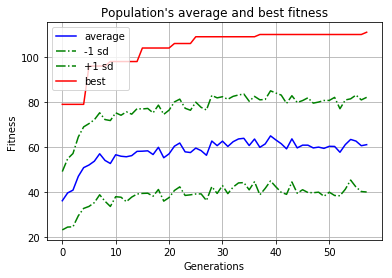

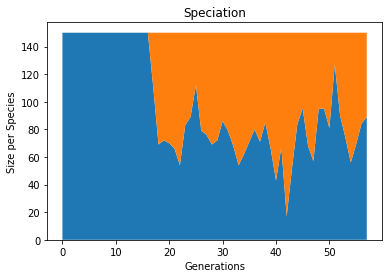

Mean genetic distance 1.620, standard deviation 0.305
Mean genetic distance 1.580, standard deviation 0.283
Mean genetic distance 1.525, standard deviation 0.262
Mean genetic distance 1.496, standard deviation 0.292
Mean genetic distance 1.469, standard deviation 0.289
Mean genetic distance 1.556, standard deviation 0.288
Mean genetic distance 1.717, standard deviation 0.367
Mean genetic distance 1.779, standard deviation 0.451
Mean genetic distance 1.688, standard deviation 0.454
Mean genetic distance 1.773, standard deviation 0.374


In [11]:
import os
import neat
import visualize

def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 0.0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for xi, xo in zip(train_x, train_y):
            output = net.activate(xi)
            genome.fitness += 1 if np.argmax(output) == xo else 0


def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5))

    # Run for up to 300 generations.
    winner = p.run(eval_genomes, 300)

    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))

    # Show output of the most fit genome against training data.
    print('\nOutput:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    for xi, xo in zip(train_x, train_y):
        output = winner_net.activate(xi)
        print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

    node_names = {-1:'x1', -2: 'x2', -3: 'x3', -4: 'x4', 0:'setosa', 1:'virginica', 2:'versicolor'}
    visualize.draw_net(config, winner, True, node_names=node_names)
    visualize.plot_stats(stats, ylog=False, view=True)
    visualize.plot_species(stats, view=True)

    p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
    p.run(eval_genomes, 10)


if __name__ == '__main__':
    # Determine path to configuration file. This path manipulation is
    # here so that the script will run successfully regardless of the
    # current working directory.
    config_path = os.path.join('.', 'config-feedforward')
    run(config_path)